# Lab-Week 10 Generative Language Model


In this laboratory session, your task is to train an autoregressive language model based on the transformer architecture, which shares similarities with the widely popular generative pre-trained transformer (GPT) developed by OpenAI. Specifically, we will be utilizing a small corpus of Shakespeare's scripts to train this model, and then leverage it to generate new text. We recommend that you review the lecture on large language models to gain a deeper understanding of the concepts relevant to this laboratory session. This will help you to better grasp the material and be more successful in completing the lab tasks.

To accomplish this, we will be using the [PyTorch](https://pytorch.org/tutorials/) framework directly. For simplicity, we will use characters as basic tokens (i.e., the language model is trained to predict the next character).


**Run the code cell below** to import PyTorch and to set the seed (for replicability).

In [1]:
import matplotlib.pyplot as plt
import math
import torch
torch.manual_seed(0)

## Exercise 1 - Data Preparation

First of all, let's download the text data from the web.

**Run the following code** to download the data.

In [2]:
# Download data from google drive repo:
!gdown --id 13WzBACCBG58H4xGzP_mGdpmmtvDUppZZ # Train data
!gdown --id 1G_VaOgs_eYs9vfkFVf0sJ1ELanq5zEuO  # Test data

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=13WzBACCBG58H4xGzP_mGdpmmtvDUppZZ
To: /content/trainset.pkl
100% 689k/689k [00:00<00:00, 160MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1G_VaOgs_eYs9vfkFVf0sJ1ELanq5zEuO
To: /content/testset.pkl
100% 306k/306k [00:00<00:00, 129MB/s]


The training and test data are stored in two pickle files:
- trainset.pkl
- testset.pkl

**Write a code to read** the downloaded data. Training data must be stored in a variable called `train_data_txt`, while test data must be stored in a variable called `test_data_txt`.

In [12]:
import pickle

# Your code here. Aim for 4 lines
train_data_txt = None
test_data_txt = None

#load the data
with open('trainset.pkl', 'rb') as f:
    train_data_txt = pickle.load(f)

with open('testset.pkl', 'rb') as f:
    test_data_txt = pickle.load(f)


print(len(train_data_txt))
print(len(test_data_txt))
print(train_data_txt[0])

6270
2790
 him? My cousin Juliet?

LUCIO:
Is she your cousin?

ISABELLA:
Adoptedly; as school-maids change the


As you can see, the data are saved in a list of strings where each element contains a string of 100 characters. For instance, if you print the first sentence of the training data  you should see:


```
 him? My cousin Juliet?

LUCIO:
Is she your cousin?

ISABELLA:
Adoptedly; as school-maids change the
```

There are 6270 strings for training and 2790 for testing.

Before moving on, we have to write some support function that allows us to train our model. The first thing to do is to figure out which set of characters is used in the training set.


**Write a code** to define the set of characters. You have to join all the training data into a single big string. Then you have to use the function `set` followed by the `sorted` one to sort the set of characters. Finally, convert everything into a list. Please, add a special character `'@'` that will be used as the begin-of-sentence token. This should be the first character appearing in the char_set list.

In [6]:
# Write your code here (aim for 2-3 lines of code)
char_set = sorted(set(list("".join(train_data_txt))))
char_set = ['@'] + char_set

print(char_set)
print(len(char_set))

['@', '\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
66


If you print `char_set` you have to see:

`['@', '\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F',..... ]`

The lenght of the output list must be 66.

As you know, we cannot feed characters into a neural network. We need to convert them into numbers. Now, you have to write a function that takes in input the dataset (either the list of strings in `train_data` or `test_data`) and converts all the characters into their corresponding indexes in the `char_set`. Please, add the begin-of-sentence ('@') token at the beginning of each text string.

As an example, consider the character sequence "hello". To feed this sequence into the language model, we must convert it into a tensor of indices. The resulting tensor would be tensor([[0, 46, 43, 50, 50, 53]]).

Note that the first element in the tensor represents the begin-of-sentence token, while the subsequent elements correspond to the indices assigned to the characters 'h', 'e', 'l', and 'o', respectively.


**Complete the code below** to convert the training and test dataset to their indexes. *Hint*: You can use the method `.index` in  `char_set` to find the index corresponding to a certain character. Remember to add the '@ 'begin-of-sentence in each string.

In [10]:
def from_chars_to_indexes(data, char_set):
  """This function converts all the strings available in the data list into
  a tensor of indexes. The conversion between char and index is done based on
  the content of the char_set. It also add the special token '@' to indicate
  begin-of-sentence.

    Arguments
    ---------
    data : List
      A list containing strings to convert.

    char_set :    List
      A list containing the set of characters. The first element corresponds to
      index 0, the second to index 1, and so on.


    Returns
    ---------
    data_index: torch.Tensor
      Tensor (N,L) containing the indexes corresponding to the input chars. N is
      the number of text chunks and L is the number of char in each chunk.
  """
  # Your code here. Aim for 8-10 lines
  data_index = []
  for string in data:
    string = '@' + string
    string_index = []
    for char in string:
      string_index.append(char_set.index(char))
    data_index.append(string_index)

  data_index = torch.tensor(data_index)

  return data_index


# Convert the train and test data
train_data = from_chars_to_indexes(train_data_txt, char_set)
test_data = from_chars_to_indexes(test_data_txt, char_set)

print(len(train_data))
print(train_data.shape)
print(test_data.shape)

6270
torch.Size([6270, 101])
torch.Size([2790, 101])


**Check your answer** by running the code below:

In [13]:
print(from_chars_to_indexes(['hello'], char_set))
assert train_data.dtype==torch.int64, "Expected out to be int64"
assert train_data.shape==(6270,101), "Unexpected shape"
assert test_data.dtype==torch.int64, "Expected out to be int64"
assert test_data.shape==(2790,101), "Unexpected shape"
assert test_data.min()==0, "Unexpected min index"
assert test_data.max()==65, "Unexpected max index"
ind =  from_chars_to_indexes(['hello'], char_set)
ind_expected = torch.Tensor([[0, 47, 44, 51, 51, 54]])
assert torch.equal(ind.float(),ind_expected), "Unexpeced index conversion"
print("Correct!")

tensor([[ 0, 47, 44, 51, 51, 54]])
Correct!


For this exercise, we convert our datasets into PyTorch data loader objects. This operation is generally convenient because the data loader object implements useful functionalities. For instance, it creates batches for us, shuffles data, etc.

For more information see [this tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

**Run the code below** to create the data loader for the training data.

In [30]:
batch_size = 128

# First, we have to convert our list into a dataset object
tr_dataset = torch.utils.data.TensorDataset(train_data)

# Finally, we can create the Dataloader object
tr_loader = torch.utils.data.DataLoader(tr_dataset, batch_size=batch_size, shuffle=True)

print(len(tr_dataset))

6270


## Exercise 2 - Create the Model

We are now ready to implement the transformer for language modeling reported in this figure:



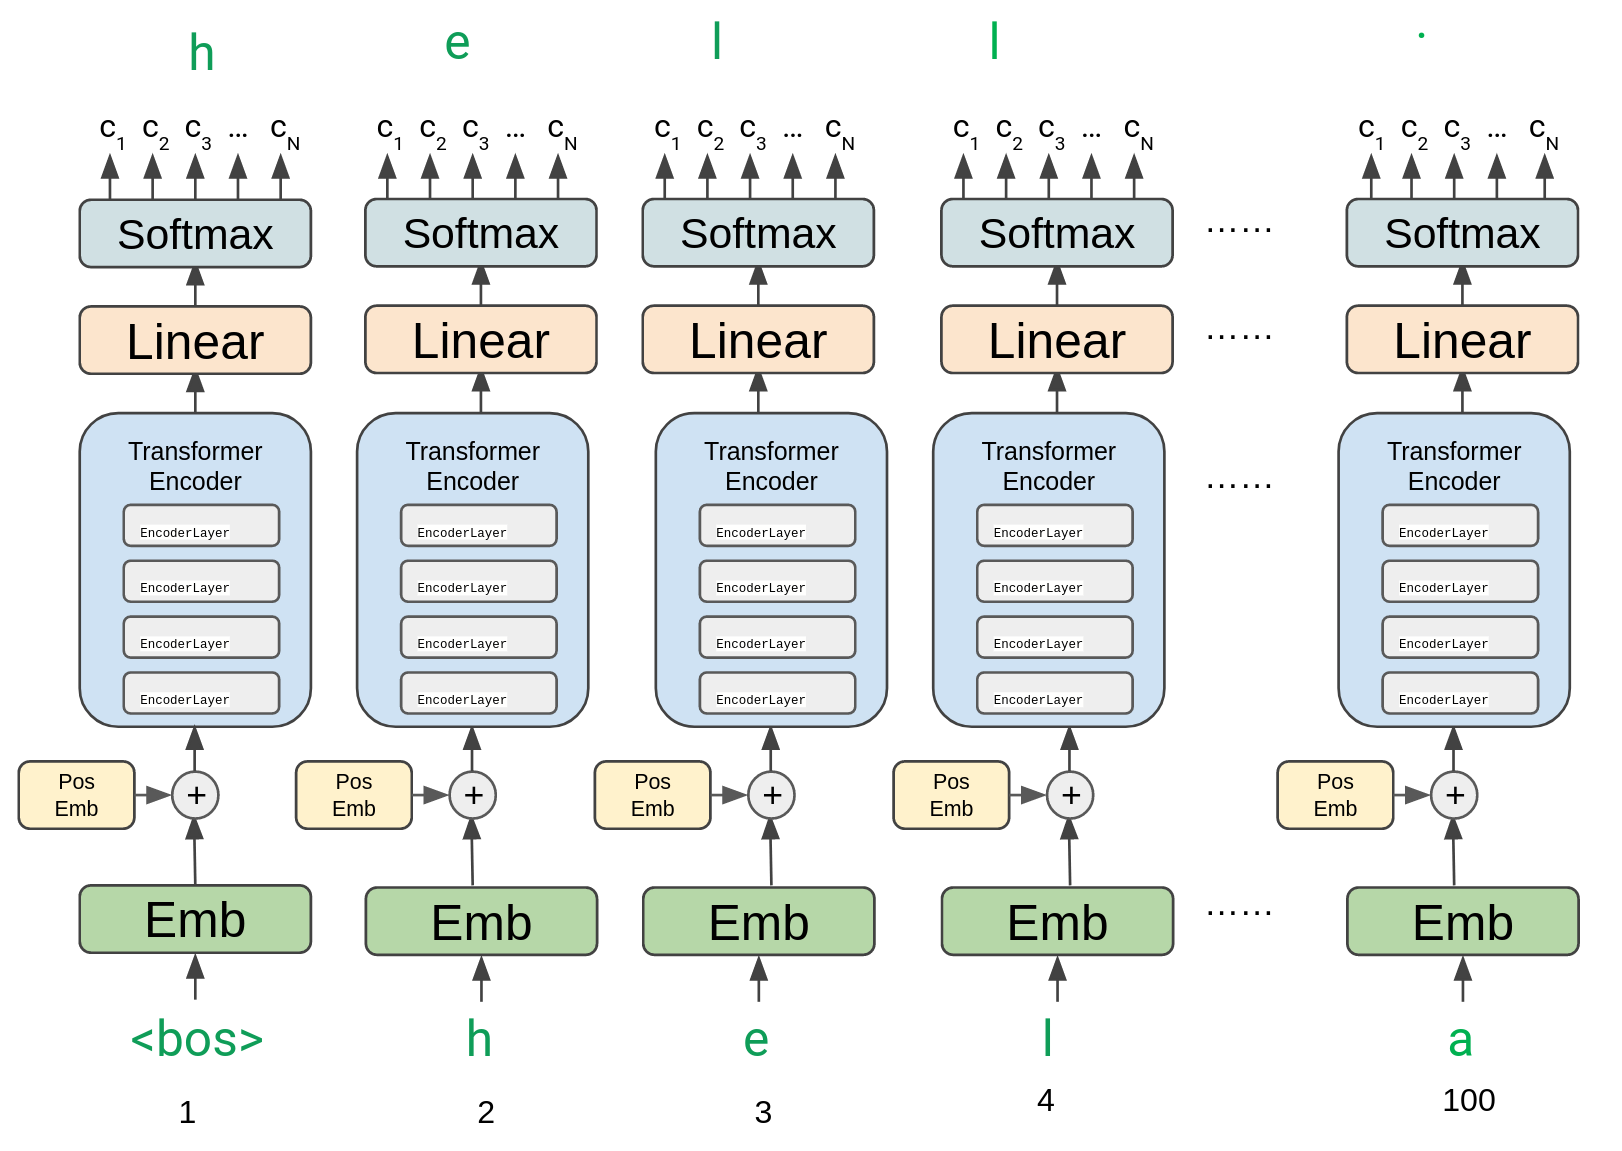

The transformer model employed in this lab accepts input characters and converts them into high-dimensional embedding vectors using `torch.nn.Embedding`. To account for position information, standard sinusoidal positional embeddings are added to the input embeddings. Next, a transformer encoder (`torch.nn.TransformerEncoder`) is applied to the embedded sequence. The output of the transformer encoder is passed through a linear transformation followed by a softmax operation to generate a probability distribution over the characters.

To compute the loss during training, we use the standard categorical cross-entropy loss function (`torch.nn.CrossEntropyLoss`). Note that this function expects the input logits (i.e., the input to the softmax function) as its argument.

We employ the Adam optimizer (`torch.optim.Adam`) to update the model's parameters during training. To mask future elements in the sequence, we need to apply a mask that prevents the model from attending to future positions in the input. Note that we do not require a padding mask since we are working with fixed-length sequences of 100 characters.


**Run the code below** to define the class for PositionalEncoding (this is the same one used in the Transformer tutorial):

In [33]:
import math
class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model, max_len=500):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        #d_model = The size of the token embedding

        #create a tensor length to max_length, fill it with floating values, and add extra dimension at position 1
        #[max_length] => [max_length,1]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # all rows , start at column 0, then every second column
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # [max_len, d_model] => [1, max_len, d_model]
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)] # [1, seq_len, d_model]
        return x

**Write a function** to generate a mask for the transformer model. This function should take the length of the sequence as input and output a square matrix. The diagonal and lower triangular parts of the matrix should contain 0s, while the upper triangular part of the matrix should contain -inf, representing future elements that the model should not attend to.

For instance, you should get something like that for a sequence of lenght 4:

$\begin{bmatrix} 0 & -\infty & -\infty & -\infty \\
0 & 0 & -\infty & -\infty \\
0 & 0 & 0  & -\infty \\
0 & 0 & 0  & 0 \\
\end{bmatrix}$

In [34]:
def generate_mask(L):
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    # Your code here. Aim for 1-2 lines
    #upper triangular matrix mask
    mask = torch.triu(torch.ones(L, L) * float('-inf'), diagonal=1)
    return mask

**Run the code below** to check the generate_mask function.

In [38]:
mask = generate_mask(4)
mask_expected = torch.Tensor([[0, -float("Inf"), -float("Inf"), -float("Inf")],
                              [0, 0, -float("Inf"), -float("Inf")],
                              [0, 0, 0, -float("Inf")],
                              [0, 0, 0, 0]])
assert torch.equal(mask,mask_expected), "Unexpeced mask"
print("Correct!")

Correct!


**Complete the code below** to implement the aforementioned transformer for language modeling. In the initialization method, you need to properly initialize the `PositionalEncoding`, `torch.nn.Embedding`, `TransformerEncoderLayer` (used dim_feedforward=d_model and `batch_first=True`), `TransformerEncoder`, `torch.nn.Linear` classes. In the forward method, you need to call all the needed computations in the right order. Do not forget to mask the future elements when you call the transformer encoder.


In [40]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TransformerLM(torch.nn.Module):

    def __init__(self, ntoken, emsize, nhead, d_model, nlayers, dropout):
        super().__init__()

        # Your code here. Aim for 5-6 lines.
        self.embedding = torch.nn.Embedding(ntoken, emsize) #[batch_size, seq_len] => [batch_size, seq_len, emsize]
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, dim_feedforward=d_model, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.linear = torch.nn.Linear(d_model, ntoken) # [batch_size, seq_len, d_model] => [batch_size, seq_len, ntoken]

        #d_model = the size of the vector for each token
        #ntoken = the number of possible tokens to predict


    def forward(self, src, src_mask):
        """
        Args:
            src: Tensor, shape [batch_size, seq_len]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [batch_size, seq_len, ntoken]
        """
        # Your code here. Aim for 4-5 lines.
        #take the standard deviation of the embedding for stable gradiants and better training performance
        src = self.embedding(src) * math.sqrt(self.embedding.embedding_dim)

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.linear(output)
        return output

**Run the following code** to instanciate the model and try it.

In [42]:
emsize = 200  # embedding dimension
d_model = 200  # dimension of the model
nlayers = 4  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 8  # number of heads in nn.MultiheadAttention
dropout = 0.2  # dropout probability

model = TransformerLM(len(char_set), emsize, nhead, d_model, nlayers, dropout)

## Exercise 3 &mdash; Training Loop
Now, we can train the model. We have to use the Categorical Cross-Entropy as an objective function. This requires properly transposing the tensor to match the dimensionality expected by this loss function. You can derive the labels $y$ by shifting the input X to the left (one way is to use `torch.roll`). Remember to remove the last time step to both inputs and labels (due to the aforementioned shift).


**Complete the code** to implement the training loop:

In [43]:
# Hyperparameters
num_epoch = 150
lr = 0.001
device = 'cuda:0' # use 'cuda:0' to speed it up.
model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
out_len = 100
src_mask = generate_mask(out_len).to(device)

def training_loop(X, model, loss, optimizer, num_epoch=500, batch_size=100, device='cpu'):

  # Training Loop
  for epoch in range(num_epoch):

    for i, X in enumerate(tr_loader):

      # X is always a list composed of 1 tensor
      X = X[0] # to extract the actual tensor from the list or tuple
       # shape: [batch_size, seq_len]

      # Get labels (right shift of X)
      y =  X[:, 1:] # [BOS, "H", "e", "l", "l", "o"] => ["H", "e", "l", "l", "o"]


      # Select 100 charachers (out of the 101 available due to bos token)
      X= X[:, :out_len]
      y= y[:, :out_len] #Your code here. Aim for 1 line.

      # Put input and labels on the right device
      X = X.to(device)
      y = y.to(device)

      # Run the Model
      out = model(X, src_mask=src_mask)


      # Compute the loss
      # out=>[batch_size, sequence_length, vocab_size] => [batch_size, vocab_size, sequence_length]
      l = loss(out.transpose(1, 2), y)

      # Update the parameters
      # Your code here. Aim for 3 line
      optimizer.zero_grad()
      l.backward()
      optimizer.step()



    # Print loss
    if (epoch + 1) % 10 == 0:
        print("Epoch %03d: Train_loss: %.4f " %(epoch+1, l.item()))

# Run the training loop
training_loop(train_data , model, loss, optimizer, num_epoch, batch_size, device)

Epoch 010: Train_loss: 1.9235 
Epoch 020: Train_loss: 1.7391 
Epoch 030: Train_loss: 1.6694 
Epoch 040: Train_loss: 1.6213 
Epoch 050: Train_loss: 1.6186 
Epoch 060: Train_loss: 1.5740 
Epoch 070: Train_loss: 1.5627 
Epoch 080: Train_loss: 1.5137 
Epoch 090: Train_loss: 1.5187 
Epoch 100: Train_loss: 1.5240 
Epoch 110: Train_loss: 1.5103 
Epoch 120: Train_loss: 1.4871 
Epoch 130: Train_loss: 1.4668 
Epoch 140: Train_loss: 1.4607 
Epoch 150: Train_loss: 1.4608 


Over the 150 epochs, you should obtain the following training losses:


```
Epoch 010: Train_loss: 1.7969
Epoch 020: Train_loss: 1.6422
Epoch 030: Train_loss: 1.5541
Epoch 040: Train_loss: 1.5666
Epoch 050: Train_loss: 1.4737
Epoch 060: Train_loss: 1.5080
Epoch 070: Train_loss: 1.4752
Epoch 080: Train_loss: 1.4760
Epoch 090: Train_loss: 1.4133
Epoch 100: Train_loss: 1.4126
Epoch 110: Train_loss: 1.4122
Epoch 120: Train_loss: 1.4237
Epoch 130: Train_loss: 1.4289
Epoch 140: Train_loss: 1.4076
Epoch 150: Train_loss: 1.4197
```



Now, let's take a look at the performance on the test set.

**Complete the code below** to compute the loss on the test data. For simplicity, we compute the test loss using a batch of 128 samples only.

In [46]:
# Switch model to eval modality
# Your code here
model.eval()

# Put test data on the right device
test_data = test_data.to(device)

# Select 128 sentences from test_data
X_test = test_data[:128]

# Derive labels (right shift)
y_test = X_test[:, 1:]

# Select 100 chars for both inputs and labels
X_test= X_test[:, :100]
y_test= y_test[:, :100]

# Running the model on test data
out = model(X_test, src_mask=src_mask)

# Compute the loss
loss_test = loss(out.transpose(1, 2), y_test)

# Print the test loss
print("Test_loss: %.4f " %(loss_test.item()))

Test_loss: 1.4437 


You should obtain a test loss very similar to the training loss:

`Test_loss: 1.3970`


## Exercise 4 &mdash; Text Generation
We are now ready to generate text from our Transformer LM. *How can we do that?*

One possible approach is the following:
1. We select the begin of sentence ('@') token is initial character.
2. We compute the output probability. We have here to apply the softmax on the last output provided by the tranformer. Use the temperature parameter in the softmax computation (see main lecture).
3. We select an output character by sampling from the output probability. The sampling can be done using `torch.multinomial` (see documentation [here](https://pytorch.org/docs/stable/generated/torch.multinomial.html)).
4. Repeat steps 2 and 3 until L=100 characters are generated.

Essentially, we generate all the characters one by one within a for loop.


**Complete the following code** to generate text.

In [185]:
import torch
import torch.nn.functional as F

def generate(model, L=100, temp=1.0):
    """Generate text of length L using a Transformer language model.

    Arguments
    ---------
    model : TransformerLM
        Pretrained Transformer model used to generate text.
    L : int
        Length of the text to generate.
    temp : float
        Temperature used for sampling.

    Returns
    -------
    output_text : str
        The generated text.
    """
    model.eval()

    # We start with the bos token (index = 0).
    # Use an integer list for current_input to avoid tensor copy warnings.
    current_input = [torch.tensor(0, device=device)]  # BOS index

    # Initialize the output text
    output_text = ''

    for i in range(L):
        # Generate a source mask for the current sequence length
        seq_len = len(current_input)
        src_mask = generate_mask(seq_len).to(device)  # generate_mask is user-defined

        # Convert current_input (list of ints) into a tensor on the right device
        inp_tensor = torch.tensor(current_input, device=device).unsqueeze(0)
        # Shape is now [1, seq_len]

        # Forward pass
        with torch.no_grad():
          out = model(inp_tensor, src_mask=src_mask)  # [1, seq_len, vocab_size]

        # Take the last time step's logits
        out = out[:, -1, :]  # [1, vocab_size]

        # Compute probabilities with temperature scaling
        probs = F.softmax(out / temp, dim=-1)  # [1, vocab_size]

        # Sample one token
        sampled_token = torch.multinomial(probs, num_samples=1).item()  # [1]

        # Convert token ID to its corresponding character (or subword)
        output_text += char_set[sampled_token]

        # Append this new token (as a Python int) to the input
        current_input.append(sampled_token)

    return output_text

# Example usage:
model.eval()
text = generate(model, L=100, temp=1.0)
print(text)


HIO:
Voncent Mercy done and stell.
I'll not reveth it will he did the oldew
To such as for our life.


If the generation step is implemented correctly, you should obtain text like this (every time you run it you sample something different):


```
st:
Well, here is not the noble gaunt?

ROMEO:
It is thou crown:
What, holy blood is the presence?

```

You should see that most of the time, the Transformer produces valid words. We can see that the network has learned to separate the parts assigned to different actors. The sequence of generated words might make some sense locally, but not globally. For better results, larger models on larger datasets must be used (which is out of the scope of this assignment).

Assuming all goes well, generating text that exceeds a length of L=100 samples may result in poor quality output. It's worth noting that the transformer was trained using fixed-length samples and has not been exposed to inputs longer than 100 characters. Additionally, adjusting the temperature hyperparameter can offer a way to balance the level of randomness with the overall quality of the generated text. Feel free to try it.

**That's all!**



